# Non parametric statistics - Projection

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from math import *
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

Dans ce Notebook on code l'estimateur par projection évoqué à la fin de la séance 1 du cours et détaillé dans le chapitre 2 du livre: https://spartacus-idh.com/028.html

L'idée est que si on veut estimer $f$ sur un intervalle $[a,b]$ (prenons $[0,1]$ pour simplilier, et qu'on dispose d'une base orthonormée $(\phi_j)_{j\ge 0}$ de $L_2([0,1])$ on peut décomposer $f$ dans cette base:
$$ f(x)=\sum_{j=1}^\infty \langle f,\phi_j\rangle \phi_j(x), $$ et un calcul simple permet de voir que $\langle f,\phi_j\rangle=\mathbb E[\phi_j(X)]$. Ainsi on peut estimer $f$ par la chaine d'approximation suivante:
$$f(x)\approx \sum_{j=1}^D \langle f,\phi_j\rangle \phi_j(x) \approx \sum_{j=1}^D \Big(\frac1n\sum_{i=1}^n\phi_j(X_i)\Big)\phi_j(x),$$ pour un certain $D$ grand (à calibrer) et où $(X_1,\ldots,X_n)$ est un échantillon i.i.d. de densité $f$.


On considère la base trigonométrique, définie de la façon suivante:
On considère la base trigonométrique qui est une base orthonormée de $L^{2}([0,1])$ définie par:
$$
\begin{cases}
\varphi_{1}(x) &=1\\
\varphi_{2j}(x) &= \sqrt{2}\cos(2\pi j x)\\
\varphi_{2j+1}(x) &= \sqrt{2}\sin(2\pi jx),
\end{cases}\quad j\ge 1,\ x\in[0,1].
$$ Dans la suite, on pose $D=2d+1$.

**Etape 1:** Coder une fonction qui renvoie les $D = 2d+1$ premières fonctions de la base trigonométrique.

In [2]:
def trigo_fun(max_degree, x):
    shape = [2*max_degree + 1] + list(x.shape)
    #print(shape)
    res = np.zeros(shape)
    res[0,:] = 1
    
    if max_degree > 0:
        for j in range(1, max_degree+1):
            res[2*j-1,:] = np.sqrt(2) * np.cos(2*np.pi*j*x)
            res[2*j,:] = np.sqrt(2) * np.sin(2*np.pi*j*x)
            
    return res

**Visualisation de la base**: Tracé des 5 premières fonctions de la base.

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


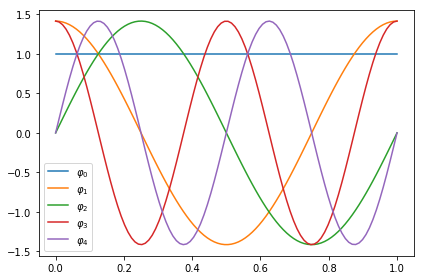

In [3]:
x = np.linspace(0, 1, 100)
y = trigo_fun(2, x)


fig, ax = plt.subplots()

ax.plot(x, y.T)
ax.legend([r"$\varphi_0$", r"$\varphi_1$", r"$\varphi_2$", r"$\varphi_3$", r"$\varphi_4$"])

fig.tight_layout()
fig.show()



**Etape 2:** Calcul de l'estimateur

In [4]:
def hat_f(X, d, grid):
    coeff = np.mean(trigo_fun(d, X),axis = 1)
    f_hat = np.sum(coeff.reshape(-1,1)*trigo_fun(d, grid), axis = 0)
    return f_hat, coeff


**Illustration**: Application: estimation d'une loi Beta. Faire varier la valeur de $d$ dans le code ci-dessous. On a un phénomène analogue à celui qu'on a décrit sur le rôle de $h$ dans le cadre de l'estimateur à noyau.
Moralement "$D=1/h$", on veut choisir $D$ grand pour avoir un biais faible, mais l'estimateur devient très volatif.
On veut choisir $D$ petit pour avoir un estimateur très lisse, mais qui risque d'être très biaisé.

array([ 1.        , -0.44289045,  0.00409143, -0.07079781,  0.00139752,
       -0.05318413,  0.00177915, -0.03322003,  0.00259031, -0.03240171,
       -0.00420857, -0.00459679,  0.02242328])

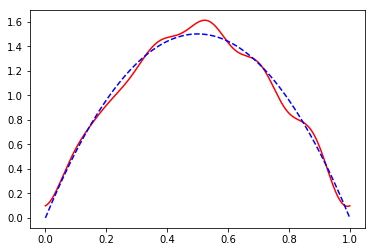

In [5]:
n = 10000
d = 6
grid = np.linspace(0,1,500)
X = st.beta.rvs(2,2, size = n)

f_hat = hat_f(X, d, grid)
f_hat[1] # Coeffs estimés
true_f =st.beta.pdf(grid,2,2)
plt.plot(grid, f_hat[0].reshape(-1,1), 'r-')
plt.plot(grid, true_f, 'b--')

Rôle de $d$?

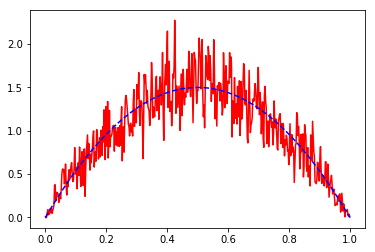

In [6]:
n = 10000
d = 200 # d=1

f_hat = hat_f(X, d, grid)
plt.plot(grid, f_hat[0].reshape(-1,1), 'r-')
plt.plot(grid, true_f, 'b--')

**Choix de $d$ "adaptatif"**: on décrit ici un méthode dite de pénalisation pour choisir le $d$ optimal (qui comme dans le cadre de l'estimateur à Noyau dépend de la régularité inconnue de la fonction $f$. Pour cela on utilise une méthode dont la théorie est justifiée dans le Chapitre 2 du livre mentionné en début de Notebook.

array([6])

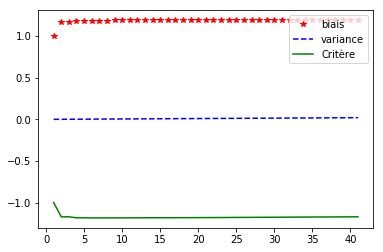

In [7]:
dmax = 20
n = 10000
X = st.beta.rvs(2,2, size = n)

coeff = np.mean(trigo_fun(dmax, X),axis = 1)
Scoeff = np.cumsum(coeff**2)
kappa = 5
Crit = -Scoeff + kappa * np.arange(1, 2*dmax + 2)/n

plt.plot(np.arange(1, 2*dmax + 2), Scoeff, 'r*', label ='biais')
plt.plot(np.arange(1, 2*dmax + 2), kappa * np.arange(1, 2*dmax + 2)/n, 'b--', label = "variance")
plt.plot(np.arange(1, 2*dmax + 2), Crit, 'g-', label = "Critère")
plt.legend()


np.where(Crit == np.min(Crit))[0]+1

In [11]:
 def adapt(dmax, X, kappa):
        coeff = np.mean(trigo_fun(dmax, X),axis = 1)
        Scoeff = np.cumsum(coeff**2)
        Crit = - Scoeff + kappa * np.arange(1, 2*dmax + 2)/n
        return int(np.floor((np.where(Crit == np.min(Crit))[0]+1)/2))

In [12]:
adapt(40, X, 1000)

1

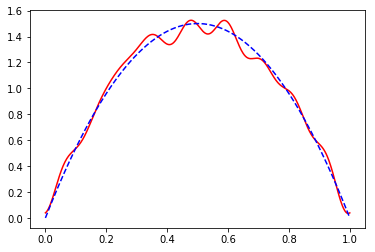

In [13]:
f_hat = hat_f(X, adapt(40, X, 2), grid)
plt.plot(grid, f_hat[0].reshape(-1,1), 'r-')
plt.plot(grid, true_f, 'b--')